### Informative score and similarity analysis

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from scipy.stats import spearmanr as scor

In [2]:
def plot_correaltions_all(dname1,name1,abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard'):
    sns.set_palette('GnBu',5)
    dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
    dnames.sort(reverse=True)
    activities=pd.Series()
    similiarities=pd.Series()
    sizes=pd.Series()
    dset_names=[]
    for dname in dnames:
        activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                         sep=',',header=0,index_col=0).abs().max(1)
        if dname1<dname:
            fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
        else:
            fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
        similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
        size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                         header=0,index_col=0)
        size=size['Set'].value_counts()
        if dname1<dname:
            similarity=similarity.max(0)
        else:
            similarity=similarity.max(1)
        sets=list(set(activity.index)&set(similarity.index)) 
        activities=pd.concat([activities,activity[sets]])   
        similiarities=pd.concat([similiarities,similarity[sets]])
        sizes=pd.concat([sizes,size[sets]])
        dset_names+=[dname]*len(sets)
    plt.figure(figsize=(5,4),dpi=300)
    sns.scatterplot(similiarities,activities,hue=dset_names)
    if sim_type=='jaccard':
        sim_label='Jaccard index'
    else:
        sim_label='Overlap coefficient'
    plt.xlabel('Similarity to '+name1+'\n('+sim_label+')',size=15)
    plt.ylabel('Informative score',size=15)
    plt.legend(fontsize=7.5)
    print(scor(activities,similiarities))

SpearmanrResult(correlation=0.23584305188949806, pvalue=3.7189093459986374e-65)


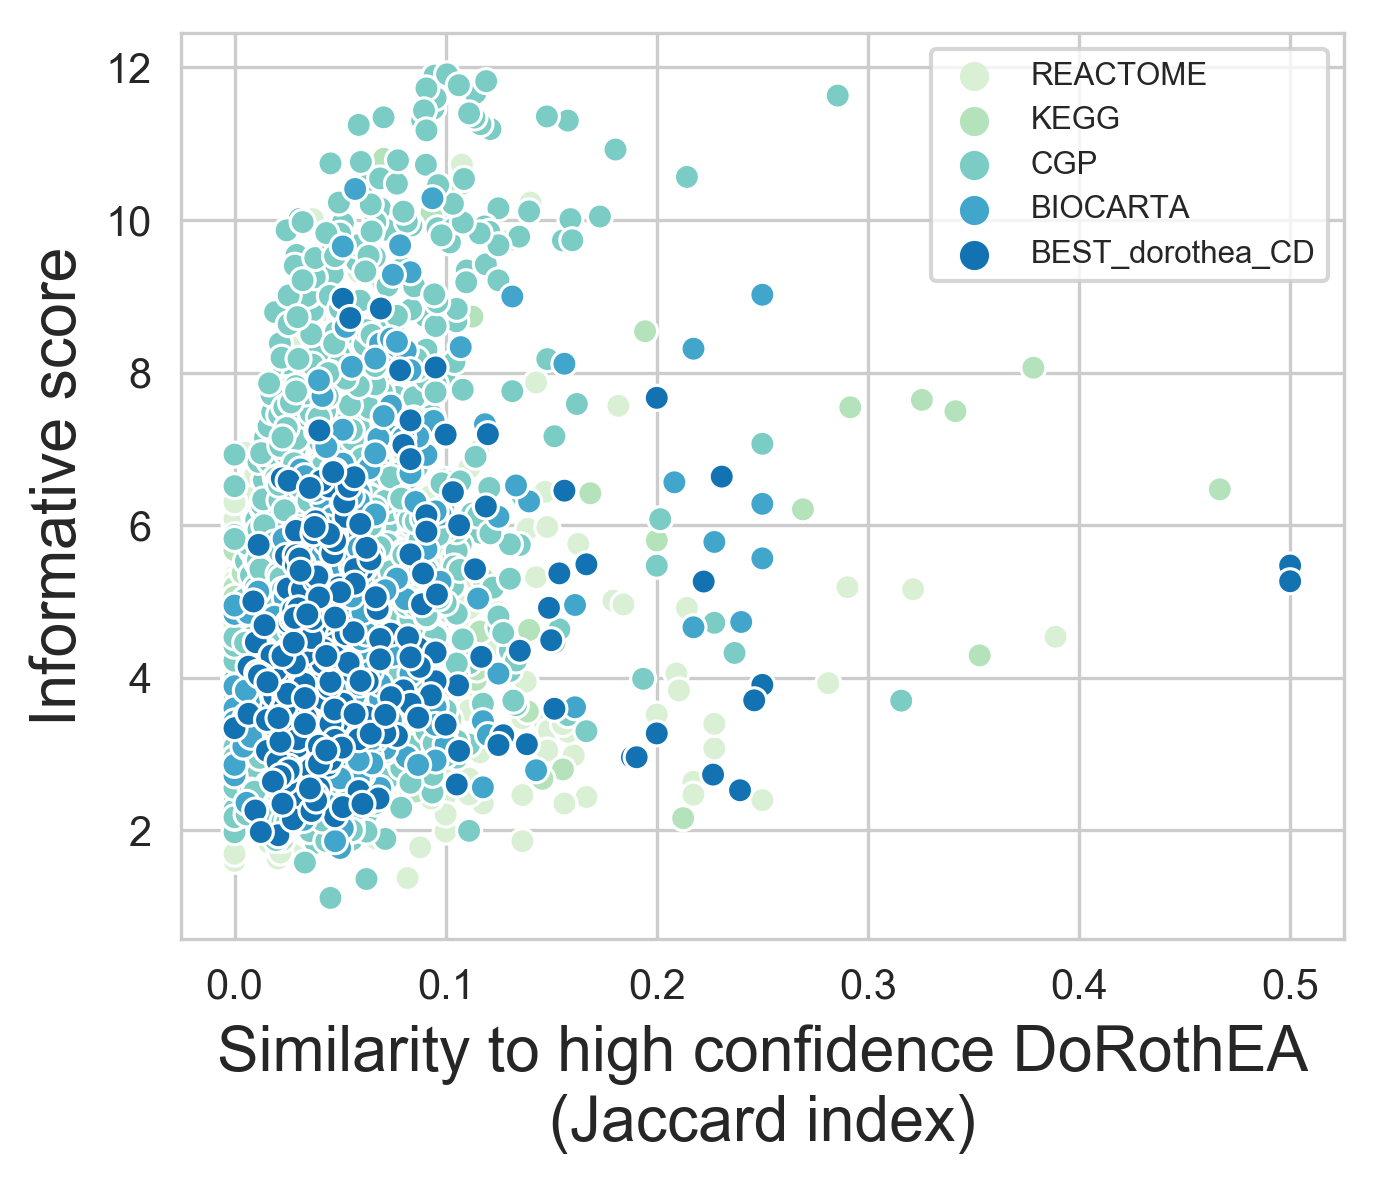

In [3]:
plot_correaltions_all('BEST_dorothea_AB','high confidence DoRothEA','_abs','_filtered','progeny','jaccard')

SpearmanrResult(correlation=0.030150997717194566, pvalue=0.03481435101401067)


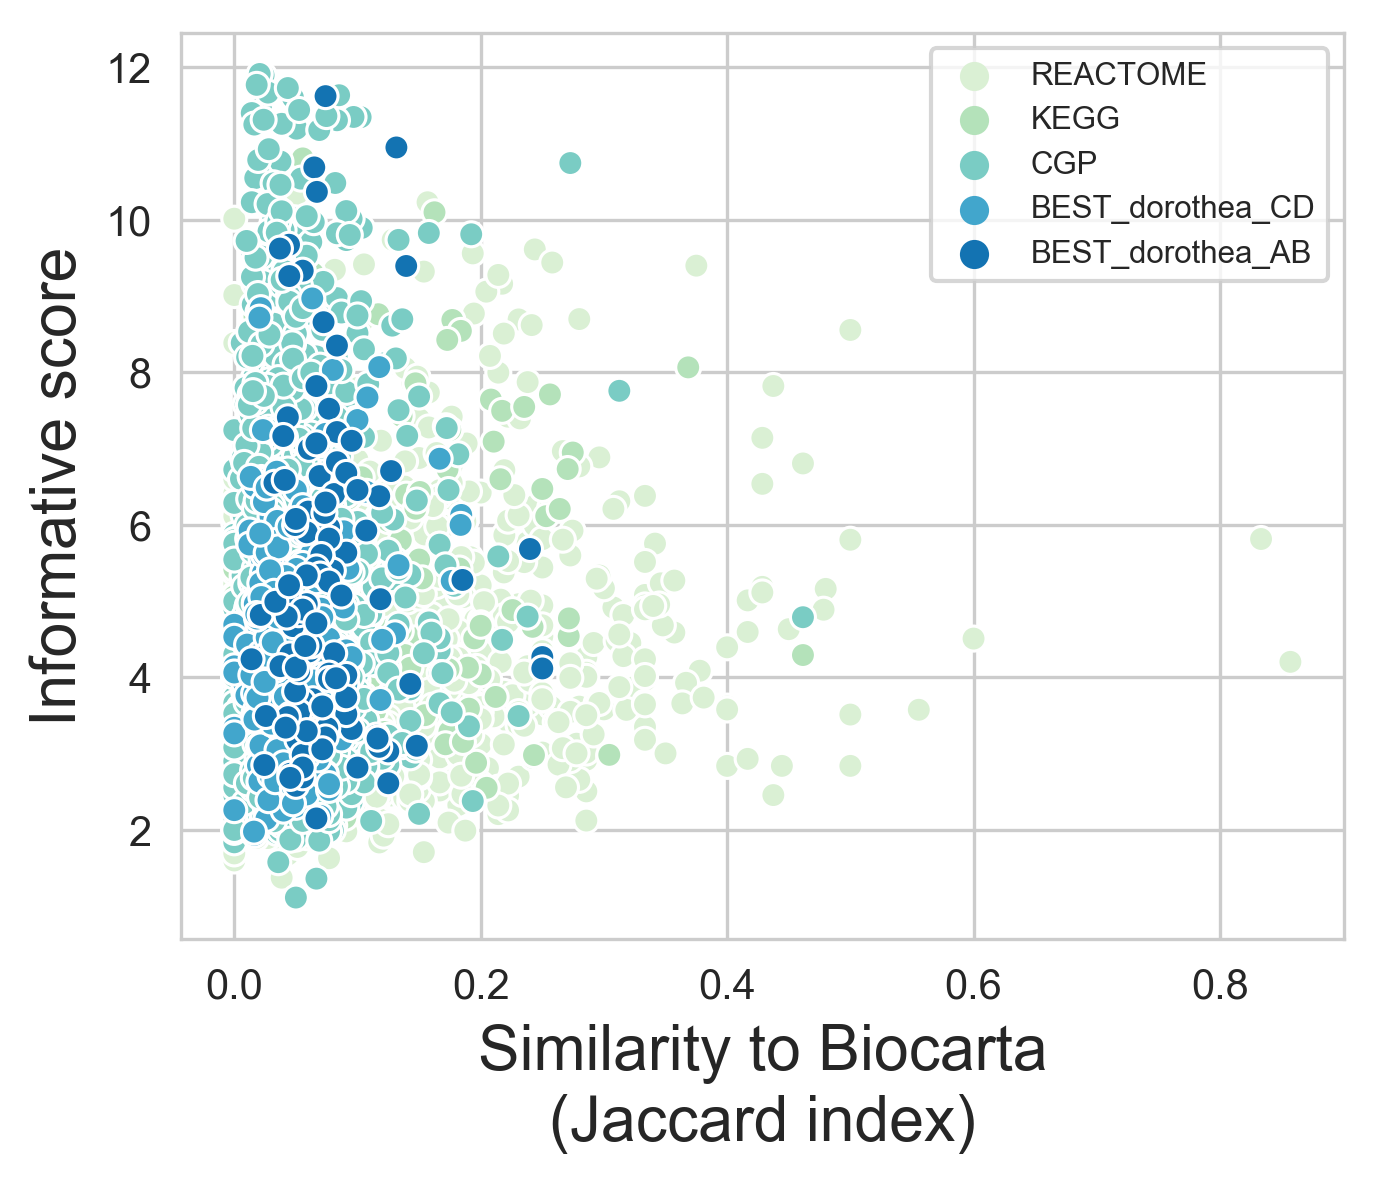

In [4]:
plot_correaltions_all('BIOCARTA','Biocarta','_abs','_filtered','progeny','jaccard')

In [5]:
def get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard'):
    dsets={'BEST_dorothea_AB':['High confidence\nDoRothEA'],
           'BEST_dorothea_CD':['Low confidence\nDoRothEA'],
           'KEGG':['KEGG'],
           'BIOCARTA':['BIOCARTA'],
           'REACTOME':['REACTOME'],
           'CGP':['CGP']}

    for dname1 in dsets:
        dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
        dnames.sort(reverse=True)
        activities=pd.Series()
        similiarities=pd.Series()
        sizes=pd.Series()
        dset_names=[]
        for dname in dnames:
            activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                             sep=',',header=0,index_col=0).abs().max(1)
            if dname1<dname:
                fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
            else:
                fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
            similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
            size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                             header=0,index_col=0)
            size=size['Set'].value_counts()
            if dname1<dname:
                similarity=similarity.max(0)
            else:
                similarity=similarity.max(1)
            sets=list(set(activity.index)&set(similarity.index)) 
            activities=pd.concat([activities,activity[sets]])   
            similiarities=pd.concat([similiarities,similarity[sets]])
            sizes=pd.concat([sizes,size[sets]])
            dset_names+=[dname]*len(sets)
        dsets[dname1].append(scor(activities,similiarities))
    
        
    return dsets

In [38]:
temp=get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_random_uniform_0',bname='progeny',sim_type='jaccard')

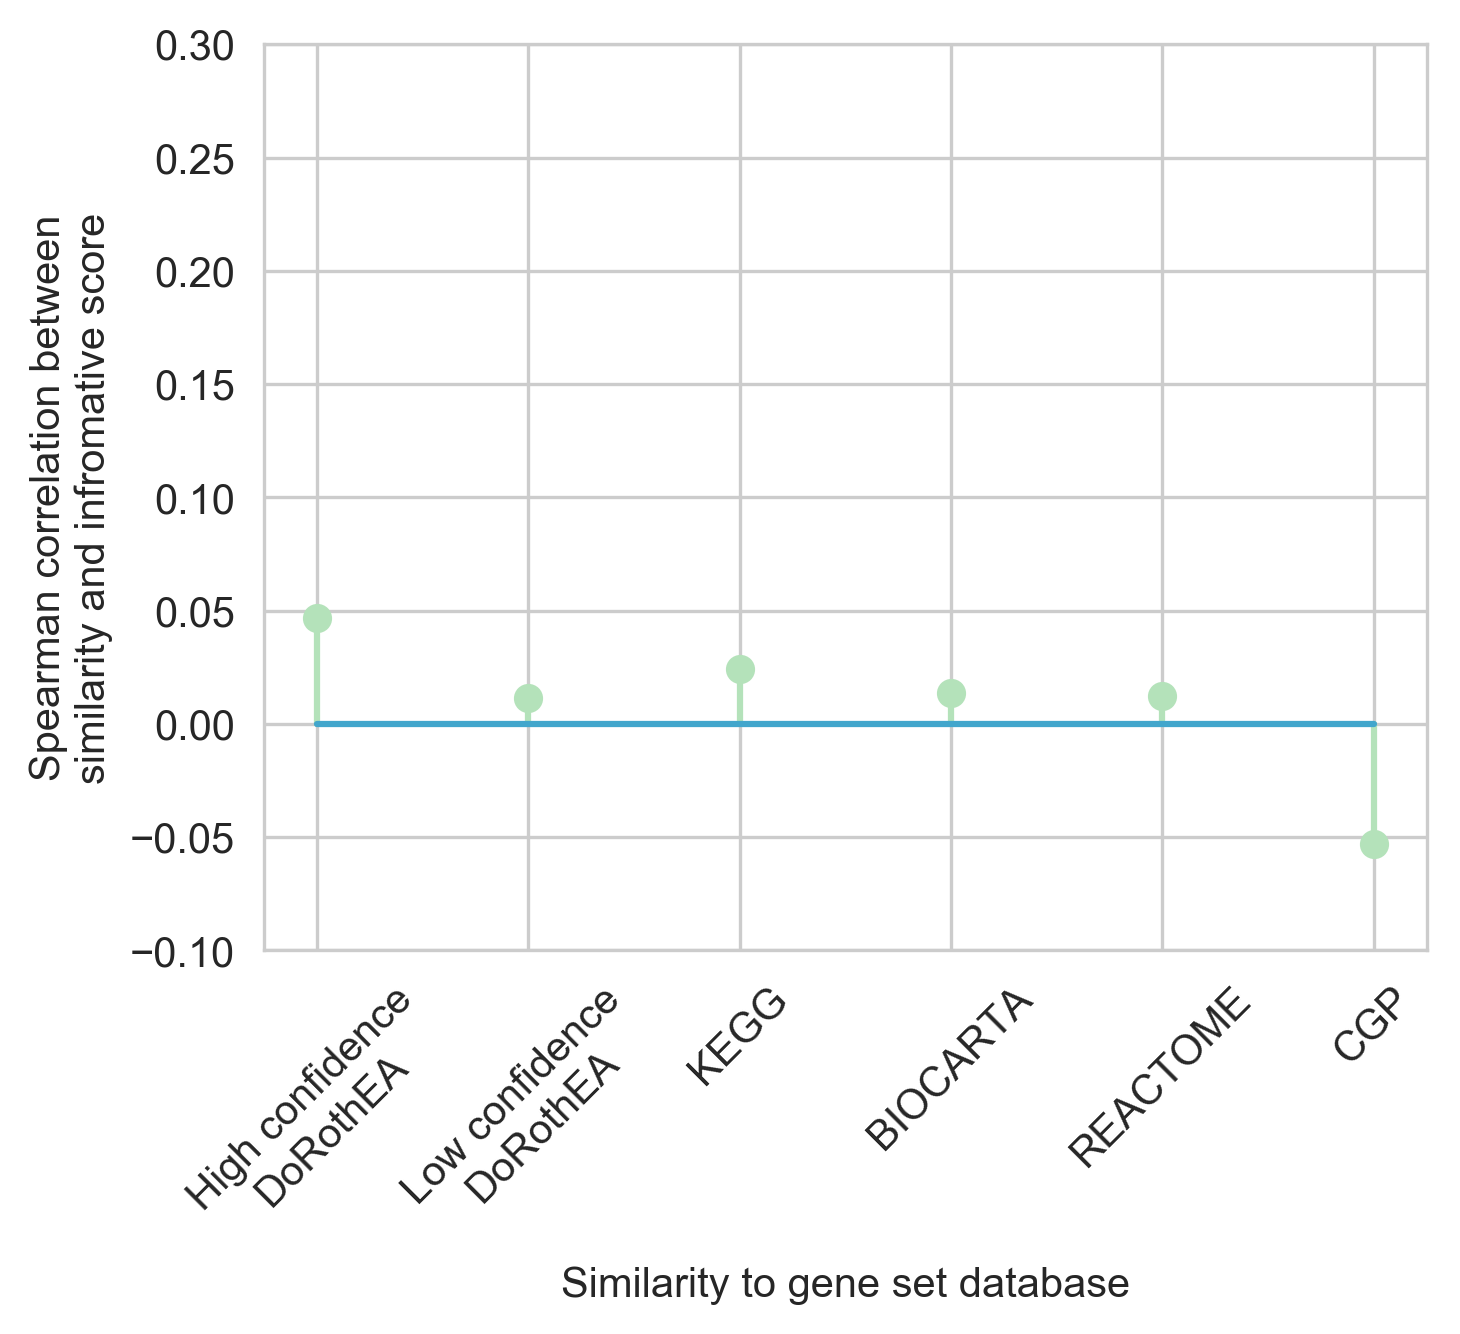

In [39]:
sns.set_palette('GnBu',2)
dsets=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
plt.figure(figsize=(5,4),dpi=300)
plt.stem(np.arange(0.5,6.5,1), [temp[x][1][0] for x in dsets])
plt.xticks(np.arange(0.5,6.5,1),[temp[x][0] for x in dsets],
          rotation=45)
plt.ylim(-0.1,0.3)
plt.xlabel('Similarity to gene set database')
plt.ylabel('Spearman correlation between\nsimilarity and infromative score')

In [40]:
ps = [temp[x][1][1] for x in temp]

In [41]:
temp

{'BEST_dorothea_AB': ['High confidence\nDoRothEA',
  SpearmanrResult(correlation=0.0468247267739718, pvalue=0.0008566966707215548)],
 'BEST_dorothea_CD': ['Low confidence\nDoRothEA',
  SpearmanrResult(correlation=0.011392268113253603, pvalue=0.42406158567569574)],
 'BIOCARTA': ['BIOCARTA',
  SpearmanrResult(correlation=0.013607089998071132, pvalue=0.3416372323019885)],
 'CGP': ['CGP',
  SpearmanrResult(correlation=-0.05288395908690351, pvalue=0.011846972316324365)],
 'KEGG': ['KEGG',
  SpearmanrResult(correlation=0.024309591695964035, pvalue=0.08584408341509071)],
 'REACTOME': ['REACTOME',
  SpearmanrResult(correlation=0.012175382531022627, pvalue=0.4567124288374994)]}

In [42]:
from statsmodels.stats.multitest import multipletests

In [43]:
multipletests(ps, method='bonferroni')

(array([ True, False, False, False, False, False]),
 array([0.00514018, 0.07108183, 1.        , 0.5150645 , 1.        ,
        1.        ]),
 0.008512444610847103,
 0.008333333333333333)

In [36]:
temp.keys()

dict_keys(['BEST_dorothea_AB', 'CGP', 'BEST_dorothea_CD', 'KEGG', 'REACTOME', 'BIOCARTA'])

In [37]:
temp

{'BEST_dorothea_AB': ['High confidence\nDoRothEA',
  SpearmanrResult(correlation=0.23584305188949806, pvalue=3.7189093459986374e-65)],
 'BEST_dorothea_CD': ['Low confidence\nDoRothEA',
  SpearmanrResult(correlation=0.07097111254219138, pvalue=5.937200262158505e-07)],
 'BIOCARTA': ['BIOCARTA',
  SpearmanrResult(correlation=0.030150997717194566, pvalue=0.03481435101401067)],
 'CGP': ['CGP',
  SpearmanrResult(correlation=0.23694811707464083, pvalue=2.7524621571459592e-30)],
 'KEGG': ['KEGG',
  SpearmanrResult(correlation=0.0809553975755057, pvalue=9.638160227397016e-09)],
 'REACTOME': ['REACTOME',
  SpearmanrResult(correlation=0.0387095440341194, pvalue=0.017745781806004033)]}